# Ajuste de espesor y porosidad de una capa simple de SP

In [1]:
import numpy
from matplotlib import pyplot
%matplotlib inline
%config InlineBackend.figure_format = "retina"
#pyplot.rcParams.update({"font.size": 14})

#import pandas
#import os
from scipy.optimize import minimize

from EffectiveIndexModels import looyenga
from RefractiveIndexDB import air, silicon
import FitUtils

In [2]:
# Genero una estructura con los parametros de la luz
LAMBDA = numpy.arange(400, 1000) # rango de longitudes de onda en nm
THETA = 5.0; # grados
POLARIZACION = 0.5; # polarizacion: 1 (p-TM), 0 (s-TE)

beam = FitUtils.BeamParameters(LAMBDA, THETA, POLARIZACION)

In [3]:
# Factor de correccion
FC = 0.8

In [4]:
# Indices de refraccion incidence y sustrato
n_incidente = air(beam.wavelength)
n_sustrato = silicon(beam.wavelength)

In [5]:
# Indices de refraccion de los componentes 1 (poros) y 2 (solido) de looyenga
n_poros = air(beam.wavelength)
n_solido = silicon(beam.wavelength)

In [6]:
# Espectro de reflectancia de la muestra y referencia medidos
r_medido = numpy.loadtxt("251121b00007.txt", delimiter='\t')
r_referencia = numpy.loadtxt("251121b00000.txt", delimiter='\t')

In [7]:
r_referencia[:, 1] *= FC

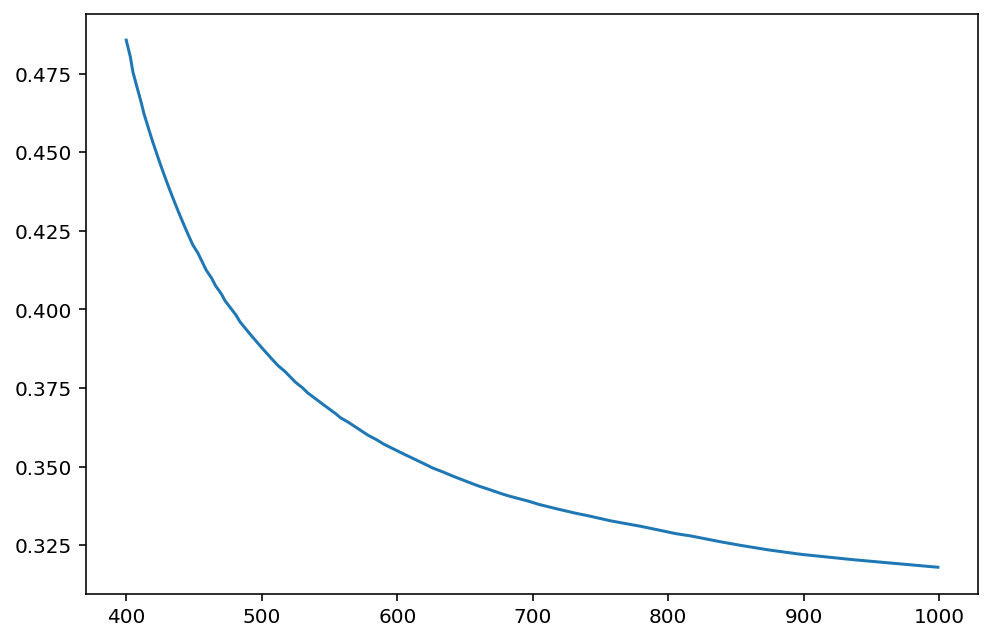

In [8]:
# Espectro de reflectancia de referencia teorico
r_teorico = FitUtils.reflectance_silicon(beam)

fig_r_teorico, ax_r_teorico = pyplot.subplots(figsize=(8, 4*4/3))
ax_r_teorico.plot(beam.wavelength, r_teorico)

In [9]:
# Cotas minimas y maximas de porosidades y espesores opticos en nanometros
LB, UB = [0.4, 11700], [0.6, 12200]

# Semillas (si no se usa el espacio de soluciones)
p_0, d_0 = 0.65, 8000

In [10]:
# Numero de puntos si se calcula el espacio de soluciones
FLAG_1 = True

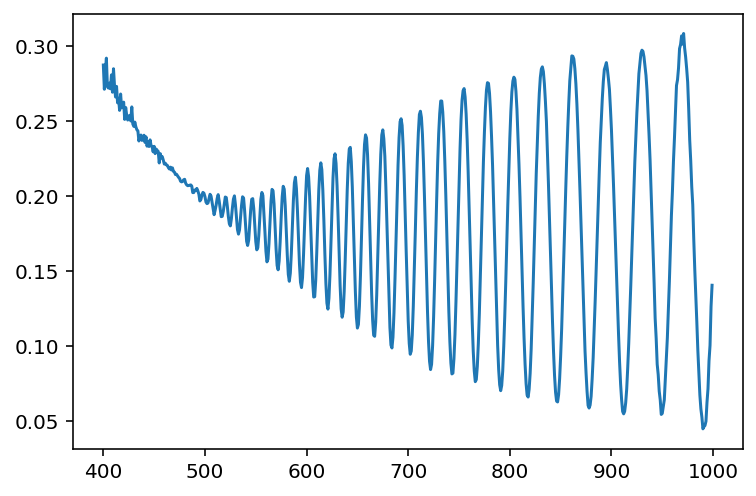

In [11]:
# Normaliza el espectro medido
r_medido_norm = FitUtils.normalize_experimental_reflectance(
    r_medido, r_referencia, r_teorico, beam,
)

pyplot.plot(beam.wavelength, r_medido_norm)
pyplot.show()

In [12]:
# Calcula el espacio de soluciones (looyenga por default) y lo grafica
error_surface, fun_val, x_0, p_vec, d_vec = FitUtils.solution_space_1(
    FLAG_1,
    LB, UB,
    beam,
    r_medido_norm,
    n_incidente,
    n_sustrato,
    n_poros,
    n_solido,
)

print("Espacio de soluciones:")
print("Error minimo: ", fun_val)
print("Porosidad: ", x_0[0])
print("Espesor optico: ", x_0[1])

Espacio de soluciones:
Error minimo:  0.009091965024300673
Porosidad:  0.4512820512820513
Espesor optico:  11969.23076923077


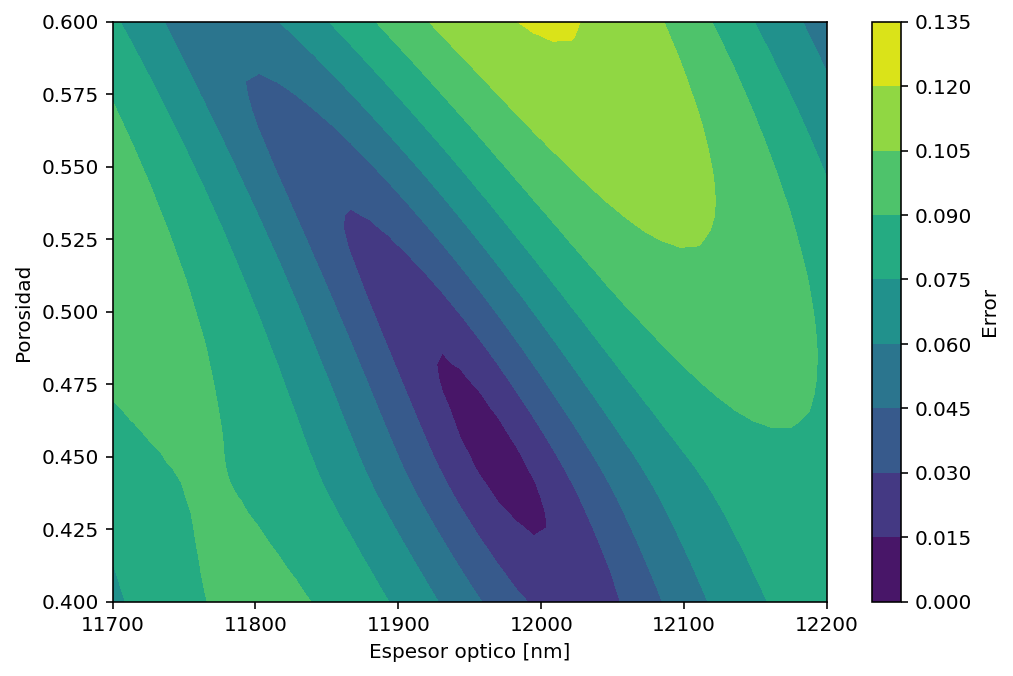

In [13]:
fig_errores, ax_errores = pyplot.subplots(figsize=(8, 4*4/3)) 
ax_cbar = ax_errores.contourf(d_vec, p_vec, error_surface)
ax_errores.set_xlabel("Espesor optico [nm]")
ax_errores.set_ylabel("Porosidad")
cbar = pyplot.colorbar(ax_cbar)
cbar.set_label("Error")

In [14]:
# Convierte espesor optico en geometrico con la inversa de looyenga
x_0_ = numpy.copy(x_0)
x_0_[1] = FitUtils.inverse_looyenga(x_0_)
x_0_

n_fit_errors = FitUtils.looyenga(n_poros, n_solido, x_0_[0])
r_fit_errors = FitUtils.reflectance(
    numpy.stack((n_incidente, n_fit_errors, n_sustrato), axis=1),
    [x_0_[1]],
    beam)

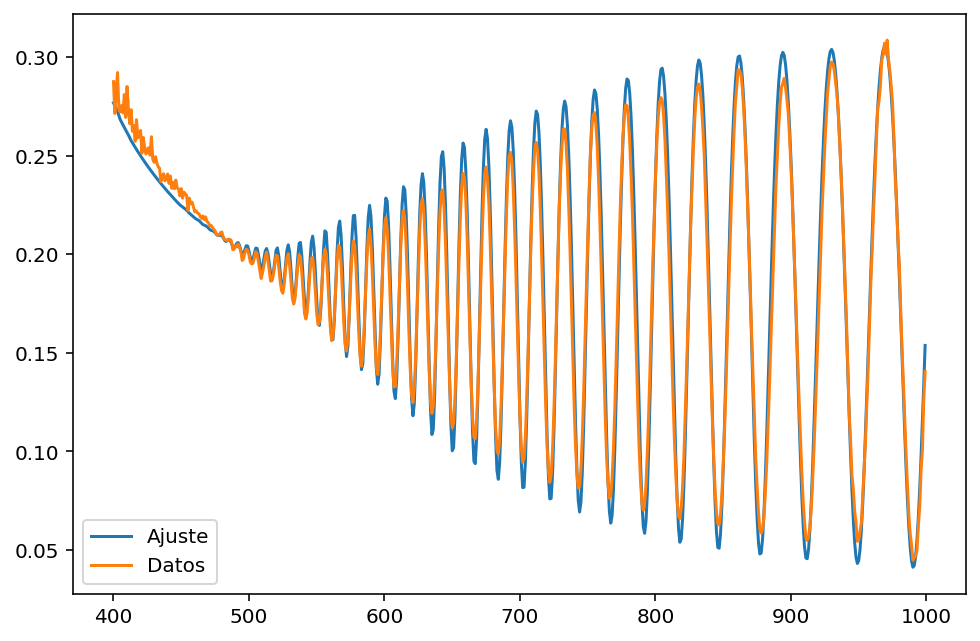

In [15]:
fig_fit, ax_fit = pyplot.subplots(figsize=(8, 4*4/3))
ax_fit.plot(beam.wavelength, r_fit_errors, label="Ajuste")
ax_fit.plot(beam.wavelength, r_medido_norm, label="Datos")
ax_fit.legend()
pyplot.show()

In [16]:
# Optimiza con algun algoritmo
resultados = dict()
algoritmos = ["nelder-mead", "powell", "BFGS"]

# Argumentos constantes a pasar a la funcion merito
arguments = (
    r_medido_norm,
    n_incidente,
    n_sustrato,
    beam,
    n_poros,
    n_solido,
    FitUtils.looyenga,
    FitUtils.inverse_looyenga,
)

bounds = [(i, j) for i, j in zip(LB, UB)]

In [17]:
resultados[algoritmos[0]] = minimize(
    FitUtils.merito1,
    x_0,
    method=algoritmos[0],
    options={'xatol': 1e-8, 'disp': True},
    args=arguments,
    bounds=bounds,
)

print(resultados[algoritmos[0]].x)

Optimization terminated successfully.
         Current function value: 0.009008
         Iterations: 112
         Function evaluations: 210
[4.54195097e-01 1.19646691e+04]


In [18]:
# Agrego al dictionary the resultados una variable x_ con el espesor fisico y la porosidad
resultados[algoritmos[0]].x_ = numpy.array([
    resultados[algoritmos[0]].x[0],
    FitUtils.inverse_looyenga(resultados[algoritmos[0]].x),
])

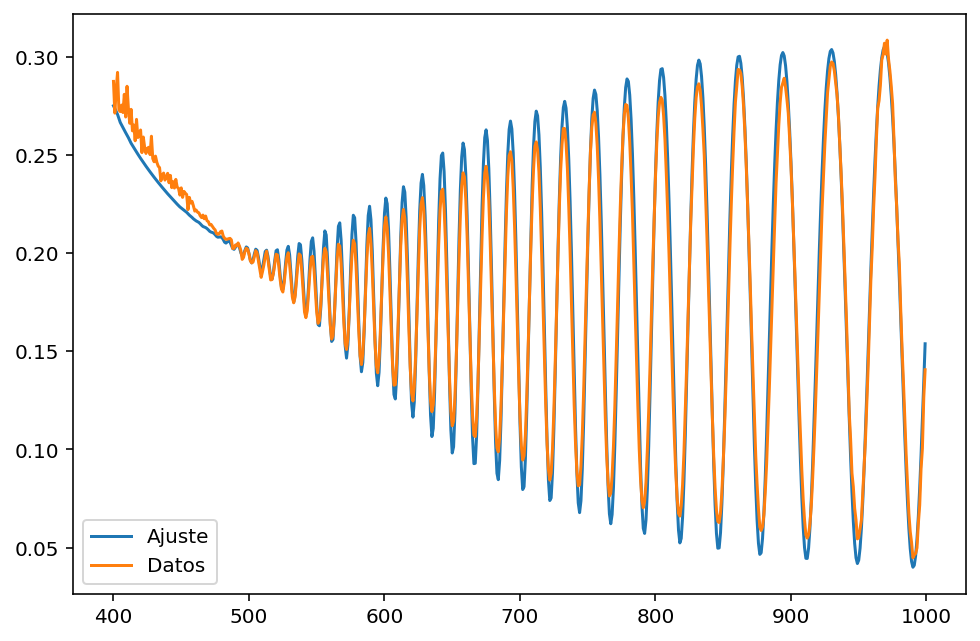

In [19]:
n_fit_errors = FitUtils.looyenga(n_poros, n_solido, resultados[algoritmos[0]].x_[0])
r_fit_errors = FitUtils.reflectance(
    numpy.stack((n_incidente, n_fit_errors, n_sustrato), axis=1),
    [resultados[algoritmos[0]].x_[1]],
    beam)

fig_fit, ax_fit = pyplot.subplots(figsize=(8, 4*4/3))
ax_fit.plot(beam.wavelength, r_fit_errors, label="Ajuste")
ax_fit.plot(beam.wavelength, r_medido_norm, label="Datos")
ax_fit.legend()
pyplot.show()